In [2]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf

In [3]:
parquet_file = [
    'data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'data/train-00003-of-00004-2d0cd200555ed7fd.parquet'
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file])

In [4]:
len(df)

800

In [5]:
df.head()

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."


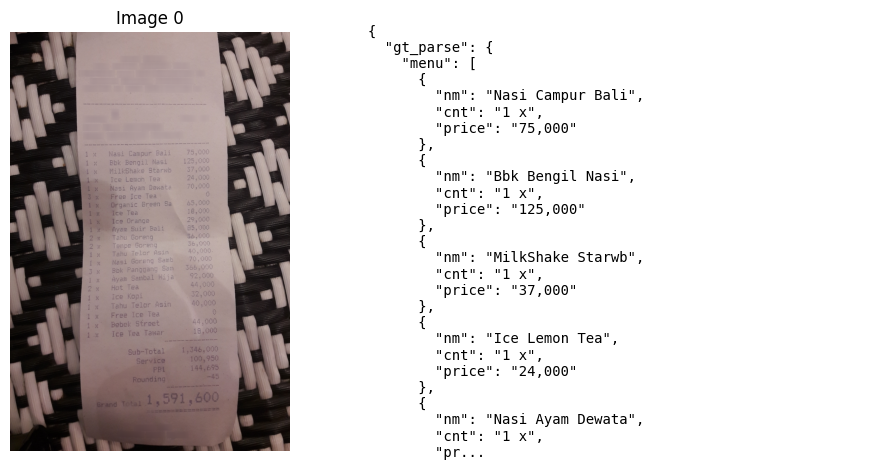

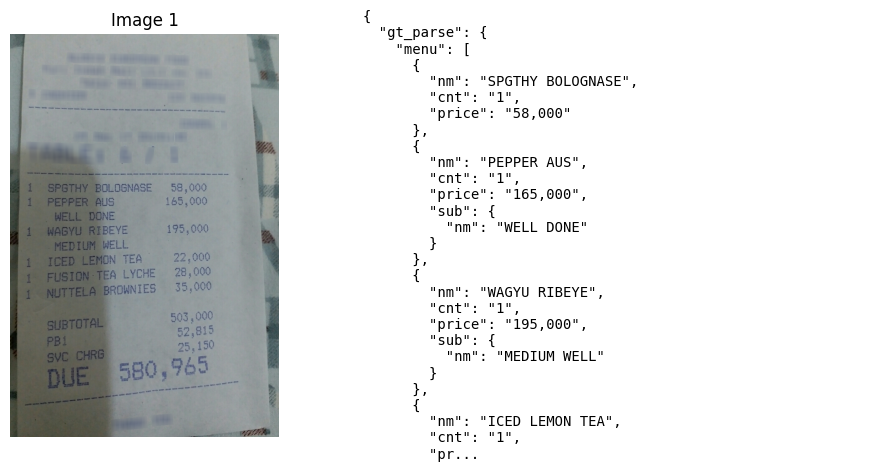

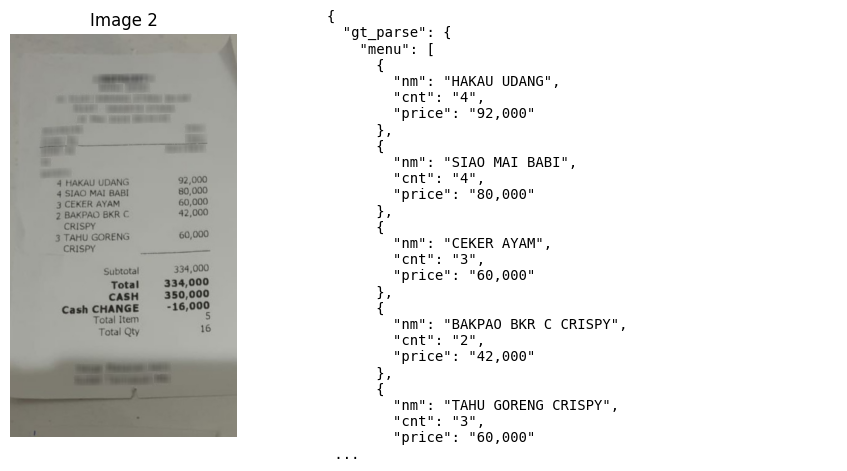

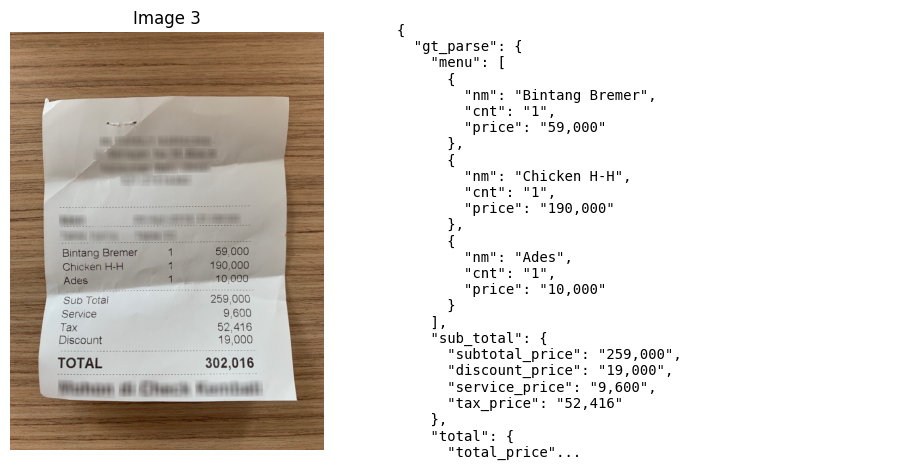

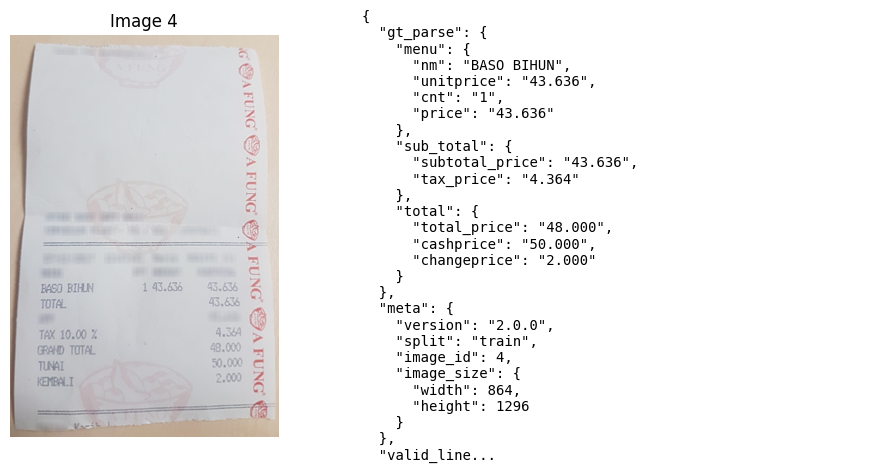

Full ground truth for image 4:
{
  "gt_parse": {
    "menu": {
      "nm": "BASO BIHUN",
      "unitprice": "43.636",
      "cnt": "1",
      "price": "43.636"
    },
    "sub_total": {
      "subtotal_price": "43.636",
      "tax_price": "4.364"
    },
    "total": {
      "total_price": "48.000",
      "cashprice": "50.000",
      "changeprice": "2.000"
    }
  },
  "meta": {
    "version": "2.0.0",
    "split": "train",
    "image_id": 4,
    "image_size": {
      "width": 864,
      "height": 1296
    }
  },
  "valid_line": [
    {
      "words": [
        {
          "quad": {
            "x2": 172,
            "y3": 836,
            "x3": 172,
            "y4": 836,
            "x1": 96,
            "y1": 800,
            "x4": 96,
            "y2": 800
          },
          "is_key": 0,
          "row_id": 2119099,
          "text": "BASO"
        },
        {
          "quad": {
            "x2": 272,
            "y3": 834,
            "x3": 272,
            "y4": 834,
       

In [6]:
for index, row in df.head(5).iterrows():
    image_data = row['image']
    image = Image.open(io.BytesIO(image_data['bytes']))
    
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the image on the left side
    ax[0].imshow(image)
    ax[0].set_title(f"Image {index}")
    ax[0].axis('off')
    
    # Parse the ground truth JSON string to a Python object
    ground_truth = json.loads(row['ground_truth'])  # Parse JSON string to a Python dict
    formatted_gt = json.dumps(ground_truth, indent=2)  # Convert dict to pretty JSON string
    
    # Display the JSON-formatted ground truth on the right side
    truncated_gt = (formatted_gt[:500] + '...') if len(formatted_gt) > 500 else formatted_gt
    ax[1].text(0, 0.5, truncated_gt, wrap=True, fontsize=10, verticalalignment='center', 
               family='monospace', transform=ax[1].transAxes)  # Use monospace font for JSON
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

    if index == 4:  # Change this to any other index if needed
        print(f"Full ground truth for image {index}:\n{formatted_gt}\n")

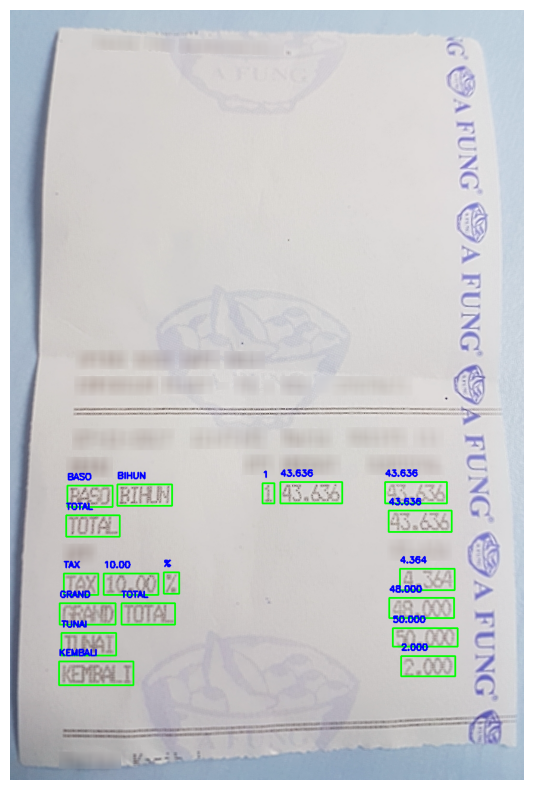

In [7]:
import json
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def display_image_with_labels(image_data, label_data, box_color=(0, 255, 0), text_color=(255, 0, 0), thickness=2, font_scale=0.5):
    """
    Menampilkan gambar dengan bounding box dan label teks menggunakan Matplotlib.
    
    Parameters:
    - image_data (dict): Data gambar dalam format bytes.
    - label_data (dict): Data label dalam format dictionary, berisi koordinat bounding box dan teks.
    - box_color (tuple): Warna bounding box (BGR).
    - text_color (tuple): Warna teks (BGR).
    - thickness (int): Ketebalan garis bounding box.
    - font_scale (float): Skala ukuran font untuk teks label.
    """
    
    # Load image and convert to OpenCV format
    image = image_data
    # image = Image.open(io.BytesIO(image_data['bytes']))
    # image = np.array(image)  # Convert PIL image to NumPy array
    
    # Set font for text
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Parse valid_line dan buat bounding box
    for line in label_data:
        for word in line['words']:
            quad = word['quad']
            
            # Define bounding box from the quad
            top_left = (quad['x1'], quad['y1'])
            bottom_right = (quad['x3'], quad['y3'])
            
            # Draw bounding box
            cv2.rectangle(image, top_left, bottom_right, box_color, thickness)
            
            # Write text label near the box
            text = word['text']
            cv2.putText(image, text, (quad['x1'], quad['y1'] - 10), font, font_scale, text_color, thickness)
    
    # Convert BGR to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

# Contoh penggunaan
index = 4
ground_truth = json.loads(df.iloc[index]['ground_truth'])  # Parse JSON string to a Python dict
image_data = df.iloc[index]['image']
image = Image.open(io.BytesIO(image_data['bytes']))
image_data = np.array(image)  
display_image_with_labels(image_data, ground_truth['valid_line'])


In [8]:
def get_dimensions(image_data):
    image = Image.open(io.BytesIO(image_data['bytes']))
    return image.size

In [9]:
df['image_dimensions'] = df['image'].apply(get_dimensions)

print(df[['image', 'image_dimensions']])

                                                 image image_dimensions
0    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
1    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
2    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (720, 1280)
3    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...     (1108, 1478)
4    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
..                                                 ...              ...
195  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...     (2304, 4096)
196  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
197  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...       (576, 864)
198  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
199  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...     (1551, 2701)

[800 rows x 2 columns]


In [10]:
#augmentation


Padding

In [11]:
import cv2
import numpy as np
import tensorflow as tf

# Fungsi untuk menyesuaikan koordinat berdasarkan padding
def adjust_coordinates_with_padding(coordinates, left_padding, top_padding):
    """
    Adjust the coordinates based on the padding added to the image.
    
    Parameters:
    coordinates (dict): Dictionary of coordinates with keys x1, y1, x2, y2, x3, y3, x4, y4.
    left_padding (int): Padding added to the left side of the image.
    top_padding (int): Padding added to the top side of the image.
    
    Returns:
    dict: Adjusted coordinates.
    """
    return {
        "x1": coordinates["x1"] + left_padding,
        "y1": coordinates["y1"] + top_padding,
        "x2": coordinates["x2"] + left_padding,
        "y2": coordinates["y2"] + top_padding,
        "x3": coordinates["x3"] + left_padding,
        "y3": coordinates["y3"] + top_padding,
        "x4": coordinates["x4"] + left_padding,
        "y4": coordinates["y4"] + top_padding
    }

# Fungsi untuk Resize, Padding, dan Penyesuaian Koordinat
def preprocess_image(image, valid_line=None, target_width=224, target_height=224):
    # Mengubah gambar ke grayscale jika gambar dalam format RGB
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Menyimpan rasio asli dari gambar
    h, w = image.shape
    
    # Menghitung rasio perubahan ukuran agar sisi terpendek sesuai dengan target
    aspect_ratio = w / h
    if aspect_ratio > 1:  # Lebar lebih besar dari tinggi
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Tinggi lebih besar atau sama dengan lebar
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    # Resize gambar sesuai ukuran baru
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Menambahkan padding untuk mencapai ukuran target
    top_padding = (target_height - new_height) // 2
    bottom_padding = target_height - new_height - top_padding
    left_padding = (target_width - new_width) // 2
    right_padding = target_width - new_width - left_padding
    
    padded_image = cv2.copyMakeBorder(
        resized_image, top_padding, bottom_padding, left_padding, right_padding, 
        borderType=cv2.BORDER_CONSTANT, value=255)  # 255 untuk padding putih
    
    # Menyesuaikan koordinat teks berdasarkan padding
    if valid_line is not None:
        for line in valid_line:
            for word in line["words"]:
                word["quad"] = adjust_coordinates_with_padding(word["quad"], left_padding, top_padding)
    
    return padded_image, valid_line

In [12]:
preprocessed_image, adjusted_valid_line = preprocess_image(image_data, ground_truth['valid_line'])


In [13]:
preprocessed_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [14]:
ground_truth['valid_line']

[{'words': [{'quad': {'x1': 133,
     'y1': 800,
     'x2': 209,
     'y2': 800,
     'x3': 209,
     'y3': 836,
     'x4': 133,
     'y4': 836},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BASO'},
   {'quad': {'x1': 217,
     'y1': 798,
     'x2': 309,
     'y2': 798,
     'x3': 309,
     'y3': 834,
     'x4': 217,
     'y4': 834},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BIHUN'}],
  'category': 'menu.nm',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x1': 461,
     'y1': 796,
     'x2': 481,
     'y2': 796,
     'x3': 481,
     'y3': 830,
     'x4': 461,
     'y4': 830},
    'is_key': 0,
    'row_id': 2119099,
    'text': '1'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x1': 491,
     'y1': 794,
     'x2': 595,
     'y2': 794,
     'x3': 595,
     'y3': 830,
     'x4': 491,
     'y4': 830},
    'is_key': 0,
    'row_id': 2119099,
    'text': '43.636'}],
  'category': 'menu.unitprice',
  'group_id': 3,


In [15]:
adjusted_valid_line

[{'words': [{'quad': {'x1': 133,
     'y1': 800,
     'x2': 209,
     'y2': 800,
     'x3': 209,
     'y3': 836,
     'x4': 133,
     'y4': 836},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BASO'},
   {'quad': {'x1': 217,
     'y1': 798,
     'x2': 309,
     'y2': 798,
     'x3': 309,
     'y3': 834,
     'x4': 217,
     'y4': 834},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BIHUN'}],
  'category': 'menu.nm',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x1': 461,
     'y1': 796,
     'x2': 481,
     'y2': 796,
     'x3': 481,
     'y3': 830,
     'x4': 461,
     'y4': 830},
    'is_key': 0,
    'row_id': 2119099,
    'text': '1'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x1': 491,
     'y1': 794,
     'x2': 595,
     'y2': 794,
     'x3': 595,
     'y3': 830,
     'x4': 491,
     'y4': 830},
    'is_key': 0,
    'row_id': 2119099,
    'text': '43.636'}],
  'category': 'menu.unitprice',
  'group_id': 3,


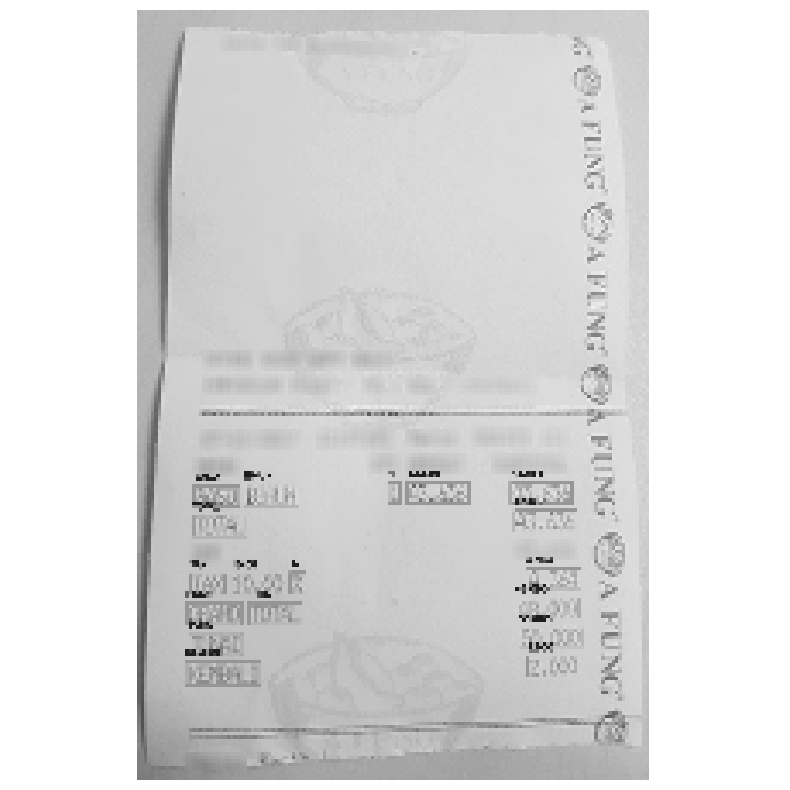

In [16]:
# Contoh penggunaan
display_image_with_labels(preprocessed_image, adjusted_valid_line)